In [0]:
import PIL
import pandas as pd
import numpy as np
import os 
from tqdm import tqdm
import logging

import matplotlib.image as mpimg
import json

from skimage.color import rgb2gray
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


import torch
import time
import copy
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as func
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.transforms import ToTensor,Resize

from torchvision import models
import torch.nn.functional as F

from torch.optim import lr_scheduler

from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt

from pylab import *
%matplotlib inline



In [0]:
RETAIN_CLASSES = [0,1,2,3,4,5,6,7,8,9]

EMBEDDING_SIZE = 512

TRAIN_IMAGES = 100

TEST_IMAGES = 300

### **Loading Data**

In [0]:
data = torchvision.datasets.MNIST(root ="./",train = True, download = True)

traindata = torch.load('./MNIST/processed/training.pt')
testdata = torch.load('./MNIST/processed/test.pt')

In [0]:
def getMNISTData_(data,retain_classes, numImages = 500):
    dataList = []
    labelList = []
    counter={}
    for i in retain_classes:
      counter[i]=0

    for i in range(len(data[0])):
        if data[1][i] in retain_classes:
            if counter[int(data[1][i])] < numImages:
              labelList.append(data[1][i])
              dataList.append(data[0][i,:,:].unsqueeze(0))
              counter[int(data[1][i])] += 1

    
    dataList = torch.cat(dataList)
    labelList = [int(x) for x in labelList]

    return dataList, labelList

def getMNISTData(retain_classes, trainImages = 500, testImages = 1000):

    data = torchvision.datasets.MNIST(root ="./",train = True, download = True)

    traindata = torch.load('./MNIST/processed/training.pt')
    testdata = torch.load('./MNIST/processed/test.pt')

    trainX,trainy = getMNISTData_(traindata, retain_classes, trainImages)
    testX,testy = getMNISTData_(testdata, retain_classes, testImages)


    return trainX,trainy,testX,testy



In [0]:
trainX,trainy,testX,testy = getMNISTData(RETAIN_CLASSES, TRAIN_IMAGES, TEST_IMAGES)

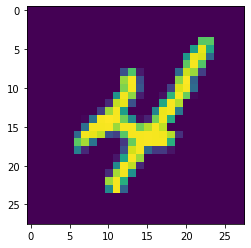

In [94]:
plt.imshow(trainX[9])

### **Utils**

#### Helper Functions

In [0]:
def getSupport(net, dataloader):

    supports = []
    labels = []

    with torch.no_grad():

        net.eval()

        for data in dataloader:
            x,y = data
            x = x.to('cuda')
            feat = net.getFeatures(x)

            supports.append(feat)
            labels.append(y)

    support = torch.cat(supports,axis=0)
    labels = torch.cat(labels,axis=0)

    return support, labels


def compareSamples(index1,index2, metric = 'cosine'):
    img1 = testX[index1].unsqueeze(0).repeat(3,1,1)
    img2 = testX[index2].unsqueeze(0).repeat(3,1,1)

    label1, label2 = testy[index1], testy[index2]

    if label1 ==label2:
        trainLabel = 1
    else:
        trainLabel = 0

    print(f"Labels are {label1} and {label2}")


    feat1 = net.getFeatures(img1.unsqueeze(0).cuda().float())
    feat2 = net.getFeatures(img2.unsqueeze(0).cuda().float())

    if metric=='cosine':
      dist = F.cosine_similarity(feat1, feat2)
    else:
      dist = F.pairwise_distance(feat1,feat2)

    loss = criterion(feat1, feat2, trainLabel)

    print(f"dist is {float(dist)} and loss is {loss}")



def getDistribution(support, labels ):

    uniqueClasses = sorted(pd.Series(labels).unique())

    NUM_COLORS = len(uniqueClasses)

    mp = cm.datad['PuBuGn']
    # get_color = matplotlib.colors.LinearSegmentedColormap.from_list(mp, colors=['r', 'y', 'g', 'b'], N=NUM_COLORS)

    get_color = plt.get_cmap('viridis')

    colorMap = {}
    for i in range(len(uniqueClasses)):
        colorMap[uniqueClasses[i]] = get_color(i/NUM_COLORS)
    
    support = support.cpu().numpy()

    scaler = StandardScaler()
    X = scaler.fit_transform(support)

    pca = PCA(n_components=2)
    pcaX = pca.fit_transform(X=X)
    varExplained = np.sum(pca.explained_variance_ratio_[:2])
    print(f"Variance Explained : {varExplained}")

    colors = [colorMap[int(x)] for x in labels]
    for i in range(len(uniqueClasses)):
      index = np.array(labels) == int(uniqueClasses[i])
      plt.scatter(pcaX[index,0], pcaX[index,1], color=colorMap[int(uniqueClasses[i])], label =int(uniqueClasses[i]))
    plt.legend()

    plt.show()


def getClassMap(uniqueClass):

    classMap = {}
    for i in range(len(uniqueClass)):
        classMap[uniqueClass[i]] = i

    classMap_ = {k:v for v,k in classMap.items()}

    return classMap, classMap_

In [0]:

def visualizeTestSample(support, labels, testFeat, testLabel, testPred ):

    uniqueClasses = sorted(pd.Series(labels).unique())

    NUM_COLORS = len(uniqueClasses)

    get_color = plt.get_cmap('viridis')

    colorMap = {}
    for i in range(len(uniqueClasses)):
        colorMap[uniqueClasses[i]] = get_color(i/NUM_COLORS)
    

    support = support.cpu().numpy()
    testFeat = testFeat.detach().cpu().numpy()

    # scaler = StandardScaler()
    # X = scaler.fit_transform(support)

    pca = PCA(n_components=2)
    pcaX = pca.fit_transform(X=support)
    testFeatX = pca.transform(X = testFeat)

    varExplained = np.sum(pca.explained_variance_ratio_[:2])
    print(f"Variance Explained : {varExplained}")
    print(f"Predicted Label : {int(testPred)}. True Label : {testLabel}")

    colors = [colorMap[int(x)] for x in labels]
    for i in range(len(uniqueClasses)):
      index = np.array(labels) == int(uniqueClasses[i])
      plt.scatter(pcaX[index,0], pcaX[index,1], color=colorMap[int(uniqueClasses[i])], label =int(uniqueClasses[i]))
    
    plt.plot(testFeatX[:,0], testFeatX[:,1], color='red', markeredgecolor = 'black', marker='H',markersize=10, label = 'test')
    plt.legend()

    plt.show()

#### Class Definitions

In [0]:



class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, dataList, labelList, prob=0.5, transform=None, classMap= None, classMap_ = None):
        """
        dataList : List of torch arrays (Images)
        labelList : List of labels
        prob : Probability of outputing a positive sample pair
        """
     
    
        self.dataList = dataList
        self.labelList = np.array(labelList)
        self.prob = prob
        self.uniqueLabels = sorted(pd.Series(labelList).unique())
        # self.transform = transform
        # self.numClasses = df.label.nunique()

        if classMap is None or classMap_ is None:
            self.classMap, self.classMap_ = getClassMap(sorted(pd.Series(labelList).unique()))
        else:
            self.classMap, self.classMap_ = classMap, classMap_
        
    
    def __len__(self):
        return len(self.dataList)
    
    def __getitem__(self, index):

        is_positive = np.random.random() < self.prob

        if is_positive:
            posLabel = np.random.choice(self.uniqueLabels,1)
            # print(f"Positive Label : {posLabel}")

            positive_indexes = np.where(self.labelList==posLabel)[0]

            img_index = np.random.choice(positive_indexes, 2, replace = False)
            index1, index2 = img_index[0], img_index[1]

            img1 = self.dataList[index1,:,:].unsqueeze(0).repeat(3,1,1)
            img2 = self.dataList[index2,:,:].unsqueeze(0).repeat(3,1,1)

            target_label = 1

        else:
            negLabels = np.random.choice(self.uniqueLabels,2, replace = False)
            # print(f"Neg labels : {negLabels}")

            index1 = np.random.choice(np.where(self.labelList== negLabels[0])[0], size = 1, replace = False)[0]
            index2 = np.random.choice(np.where(self.labelList== negLabels[1])[0], size = 1, replace = False)[0]

            # print(index1)

            img1 = self.dataList[index1,:,:].unsqueeze(0).repeat(3,1,1)
            img2 = self.dataList[index2,:,:].unsqueeze(0).repeat(3,1,1)

            target_label = 0

        img1 = img1/255.0
        img2 = img2/255.0

        
        return img1,img2, target_label

In [0]:
class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, dataList, labelList, transform=None, classMap= None, classMap_ = None):
    
    
    self.df = dataList
    self.labelList = labelList
    self.transform = transform

    if classMap is None or classMap_ is None:
        self.classMap, self.classMap_ = getClassMap(sorted(pd.Series(labelList).unique()))
    else:
        self.classMap, self.classMap_ = classMap, classMap_
        


    
  def __len__(self):
    
    return len(self.df)
    
  def __getitem__(self, index):
    
    img = self.df[index,:,:].unsqueeze(0).repeat(3,1,1)
    
    label = int(self.labelList[index])
            
    img = img/255.0
    
    return img, label



In [0]:
class Net(nn.Module):

    def __init__(self,activation = 'relu'):
        super().__init__()

        self.activation = activation
        self.conv1 = nn.Conv2d(3, 64, 7)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.conv3 = nn.Conv2d(128, 256, 5)
        self.linear1 = nn.Linear(2304, EMBEDDING_SIZE)

        # self.linear2 = nn.Linear(512, 3)

    def getFeatures(self, x):

        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)

        x = x.view(x.shape[0], -1)
        x = self.linear1(x)
        # x = self.linear2(x)
        if self.activation =='relu':
          x = F.relu(x)
        else:
          x = torch.sigmoid(x)

        return x

    def forward(self, x1, x2):

        out1 = self.getFeatures(x1)
        out2 = self.getFeatures(x2)

        return out1, out2

class resnetSiamese(torch.nn.Module):
    def __init__(self, pretrained = True, activation = 'relu'):

        super(resnetSiamese, self).__init__()
        
        resnetModel_ = torchvision.models.resnet.resnet50(pretrained=pretrained)

        self.activation = activation

        self.conv1 = resnetModel_.conv1
        self.bn1 = resnetModel_.bn1
        self.relu = resnetModel_.relu
        self.maxpool = resnetModel_.maxpool
        self.layer1 = resnetModel_.layer1
        self.layer2 = resnetModel_.layer2
        self.layer3 = resnetModel_.layer3
        self.layer4 = resnetModel_.layer4
        self.avgpool = resnetModel_.avgpool
        self.fc = resnetModel_.fc
        self.linear1 = nn.Linear(2048,EMBEDDING_SIZE)

    def getFeatures(self,x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        if self.activation =='relu':
          x = F.relu(x)
        else:
          x = torch.sigmoid(x)

        x = self.linear1(x)
        
        if self.activation =='relu':
          x = F.relu(x)
        else:
          x = torch.sigmoid(x)
        
        
        return x

    def forward(self,x1, x2):

        x1 = self.getFeatures(x1)
        x2 = self.getFeatures(x2)

        return x1, x2

In [0]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=15.0, metric='cosine'):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.metric = metric

    def forward_cosine(self, output1, output2, label):
        euclidean_distance = 1 - torch.nn.functional.cosine_similarity(output1, output2)
        # print(euclidean_distance)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        return loss_contrastive
      
    def forward_euclidean(self, output1, output2, label):
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        # print(euclidean_distance)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

    def forward(self, output1, output2, label):

      if self.metric =='cosine':
        loss = self.forward_cosine(output1, output2, label)
      else:
        loss = self.forward_euclidean(output1, output2, label)
      
      return loss



### **Training**

In [0]:
trainDataset = SiameseDataset(trainX, trainy, prob = 0.5)

trainDataset_ = ImageDataset(trainX, trainy)
testDataset_ = ImageDataset(testX, testy)

train_dataloader = DataLoader(trainDataset,
                        shuffle=True,
                        num_workers=1,
                        batch_size=10)

train_dataloader_ = DataLoader(trainDataset_,
                        shuffle=False,
                        num_workers=1,
                        batch_size=10)

test_dataloader_ = DataLoader(testDataset_,
                        shuffle=False,
                        num_workers=1,
                        batch_size=10)

In [0]:
### Select Model type
net = resnetSiamese(pretrained = True, activation ='relu')
# net = Net(activation = 'relu')



net.to('cuda')

criterion = ContrastiveLoss(margin=0.5, metric='cosine')

counter = []
loss_history = [] 
iteration_number= 0

# ### Code to freeze resnet base layers
# for name,module in net.named_children():
#     for param in module.parameters():
#         param.requires_grad = False
#         if name == 'fc' or name =='linear1':
#             param.requires_grad = True


# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()) ,lr = 0.0001 )

Variance Explained : 0.2542048990726471


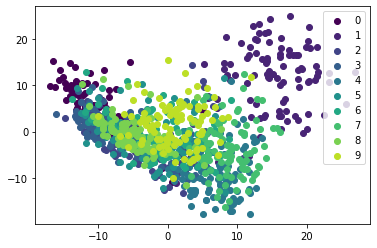

Epoch Loss : 0.03325181031599641
Variance Explained : 0.35706087946891785


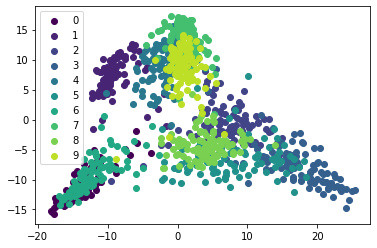

Epoch Loss : 0.01441747504635714
Variance Explained : 0.3392401337623596


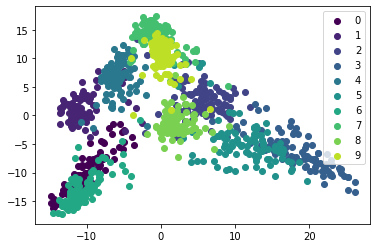

Epoch Loss : 0.0073208898026496175
Variance Explained : 0.31797483563423157


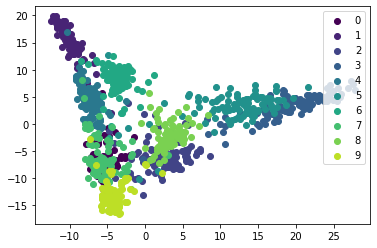

Epoch Loss : 0.00452734889157
Variance Explained : 0.3062605857849121


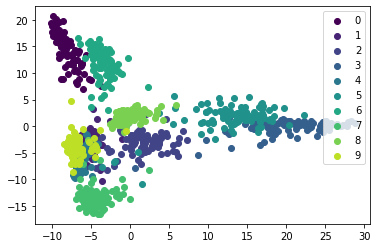

Epoch Loss : 0.002701213100372115
Variance Explained : 0.31038898229599


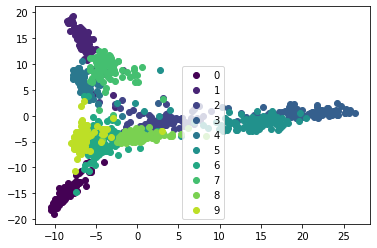

Epoch Loss : 0.0025710078301199248
Variance Explained : 0.3093150556087494


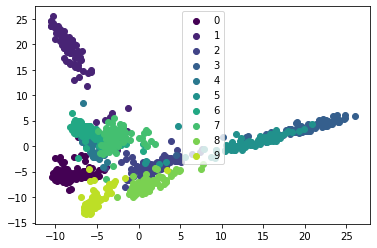

Epoch Loss : 0.0027649529015252483
Variance Explained : 0.2907528877258301


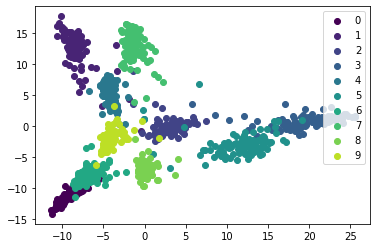

Epoch Loss : 0.002648113247432775
Variance Explained : 0.291312038898468


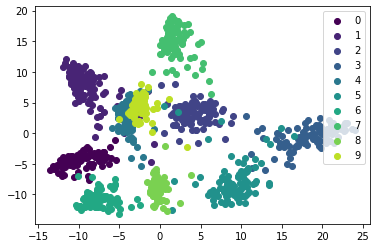

Epoch Loss : 0.0011967675942287314
Variance Explained : 0.283266544342041


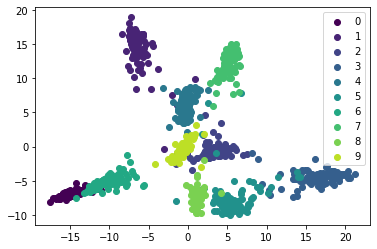

Epoch Loss : 0.001875344940699506
Variance Explained : 0.27579936385154724


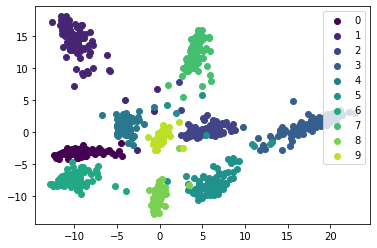

In [104]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()) ,lr = 0.00001 )


net.train()

for epoch in range(0,10):
    epoch_loss = []
    support, labels = getSupport(net, train_dataloader_)
    getDistribution(support, labels)
    plt.show()

    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
 
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()

        epoch_loss.append(loss_contrastive.item())


    print(f"Epoch Loss : {np.mean(epoch_loss)}")


support, labels = getSupport(net, train_dataloader_)
getDistribution(support, labels)
plt.show()

    

In [105]:
pred, label = getPred(net, train_dataloader_, testDataset_, metric ='cosine')

accuracy_score(label, pred)

100%|██████████| 3000/3000 [00:42<00:00, 70.72it/s]


0.9376666666666666

In [416]:
compareSamples(1,2, metric='euclidean')

Labels are 5 and 5
dist is 172.70042419433594 and loss is 29825.435546875


In [417]:
compareSamples(1,3, metric='euclidean')

Labels are 5 and 7
dist is 481.567626953125 and loss is 0.0


### **Predictions**

In [0]:
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

In [0]:
def getPred(net, train_dataloader_, testDataset_, metric = 'cosine', usePCA = False, PCA_components = 10):

    support, labels = getSupport(net, train_dataloader_)

    X = support.cpu().numpy()

    pca = PCA(n_components=PCA_components)
    if usePCA:
      X = pca.fit_transform(X=X)

    knnModel = KNeighborsClassifier(n_neighbors=8,metric=metric)
    knnModel.fit(X, labels)

    labelList = []
    predList = []
    for i in tqdm(range(len(testDataset_))):
        testX = net.getFeatures(testDataset_[i][0].unsqueeze(0).cuda()).detach().cpu().numpy()
        label = int(testDataset_[i][1])
        if usePCA:
          testX = pca.transform(testX)

        pred = knnModel.predict(testX)
        predList.append(pred[0])
        labelList.append(label)

    
    return predList, labelList


In [544]:
testPred, testLabels = getPred(net, train_dataloader_, testDataset_, usePCA=True)

accuracy_score(testPred, testLabels)

100%|██████████| 1500/1500 [00:23<00:00, 65.22it/s]


0.9573333333333334

### **Error Analysis**

In [0]:
errorIndices = []
for i in range(len(testPred)):
  if testPred[i]!=testLabels[i]:
    errorIndices.append(i)


Variance Explained : 0.9842839241027832
Predicted Label : 5. True Label : 3


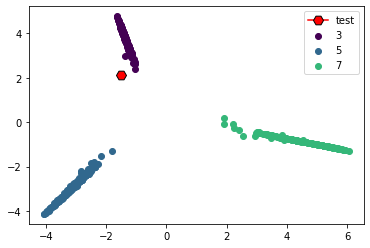

In [526]:

index = errorIndices[9]

testFeat = net.getFeatures(testDataset_[index][0].unsqueeze(0).cuda())


visualizeTestSample(support, labels, testFeat, testLabels[index], testPred[index])



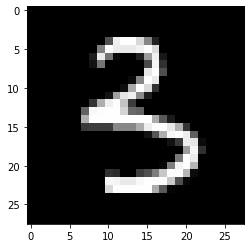

In [527]:
plt.imshow(testDataset_[index][0].permute(1,2,0))

In [0]:

def visualizeTestSample(support, labels, testFeat, testLabel, testPred ):

    uniqueClasses = sorted(pd.Series(labels).unique())

    NUM_COLORS = len(uniqueClasses)

    get_color = plt.get_cmap('viridis')

    colorMap = {}
    for i in range(len(uniqueClasses)):
        colorMap[uniqueClasses[i]] = get_color(i/NUM_COLORS)
    

    support = support.cpu().numpy()
    testFeat = testFeat.detach().cpu().numpy()

    # scaler = StandardScaler()
    # X = scaler.fit_transform(support)

    pca = PCA(n_components=2)
    pcaX = pca.fit_transform(X=support)
    testFeatX = pca.transform(X = testFeat)

    varExplained = np.sum(pca.explained_variance_ratio_[:2])
    print(f"Variance Explained : {varExplained}")
    print(f"Predicted Label : {int(testPred)}. True Label : {testLabel}")

    colors = [colorMap[int(x)] for x in labels]
    for i in range(len(uniqueClasses)):
      index = np.array(labels) == int(uniqueClasses[i])
      plt.scatter(pcaX[index,0], pcaX[index,1], color=colorMap[int(uniqueClasses[i])], label =int(uniqueClasses[i]))
    
    plt.plot(testFeatX[:,0], testFeatX[:,1], color='red', markeredgecolor = 'black', marker='H',markersize=10, label = 'test')
    plt.legend()

    plt.show()